In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.10.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = 'C:/Users/82108/Desktop/2023boot/python/'
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [600, 600]
IMG_SIZE = 600
EPOCHS = 25

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/Facotry/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/Facotry/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [5]:
COUNT_OK = len([filename for filename in train_filenames if "OK" in filename])
print("OK images count in training set: " + str(COUNT_OK))

COUNT_NG = len([filename for filename in train_filenames if "NG" in filename])
print("NG images count in training set: " + str(COUNT_NG))

OK images count in training set: 308
NG images count in training set: 292


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\82108\\Desktop\\2023boot\\python\\\\Facotry\\train\\OK\\1_105345.png'
b'C:\\Users\\82108\\Desktop\\2023boot\\python\\\\Facotry\\train\\OK\\1_154859.png'
b'C:\\Users\\82108\\Desktop\\2023boot\\python\\\\Facotry\\val\\OK\\1_105211.png'
b'C:\\Users\\82108\\Desktop\\2023boot\\python\\\\Facotry\\val\\OK\\2_175119.png'
b'C:\\Users\\82108\\Desktop\\2023boot\\python\\\\Facotry\\train\\OK\\1_105008.png'


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 600
Validating images count: 150


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/Facotry/train/*"))])
CLASS_NAMES

array(['NG', 'OK'], dtype='<U2')

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "NG"

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [11]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)

    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(img)

    img = tf.image.random_flip_up_down(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (600, 600, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/Facotry/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

47

In [16]:
classify_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/Facotry/photo/*'))
classify_IMAGE_COUNT = tf.data.experimental.cardinality(classify_list_ds).numpy()
classify_ds = classify_list_ds.map(process_path, num_parallel_calls=None)
classify_ds = classify_ds.batch(BATCH_SIZE)

classify_IMAGE_COUNT


1127

In [17]:
for image, label in classify_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

classify_ds

Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]
Image shape:  (8, 600, 600, 3)
Label:  [False False False False False False False False]


<BatchDataset element_spec=(TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [20]:
image_batch1, label_batch1 = next(iter(test_ds))

In [21]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(4,3,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("NG")
        else:
            plt.title("OK")
        plt.axis("off")

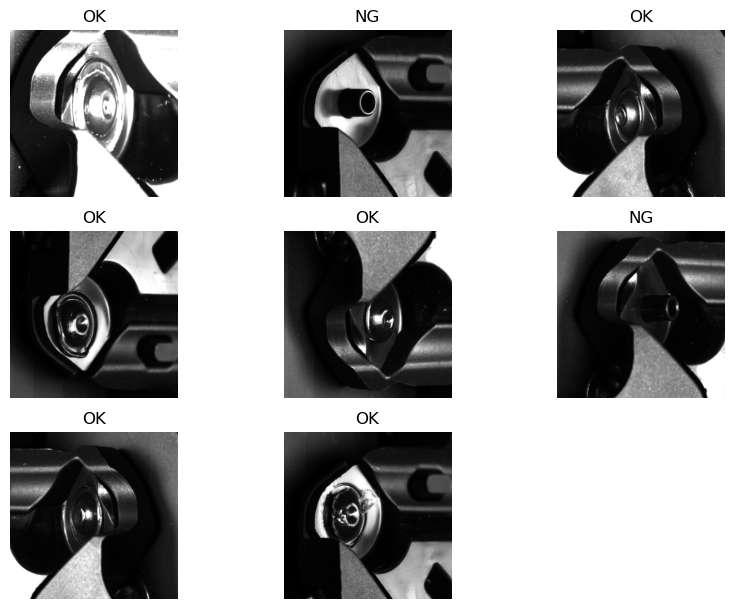

In [22]:
show_batch(image_batch1.numpy(), label_batch1.numpy())

In [23]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(4,3,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("NG")
        else:
            plt.title("OK")
        plt.axis("off")

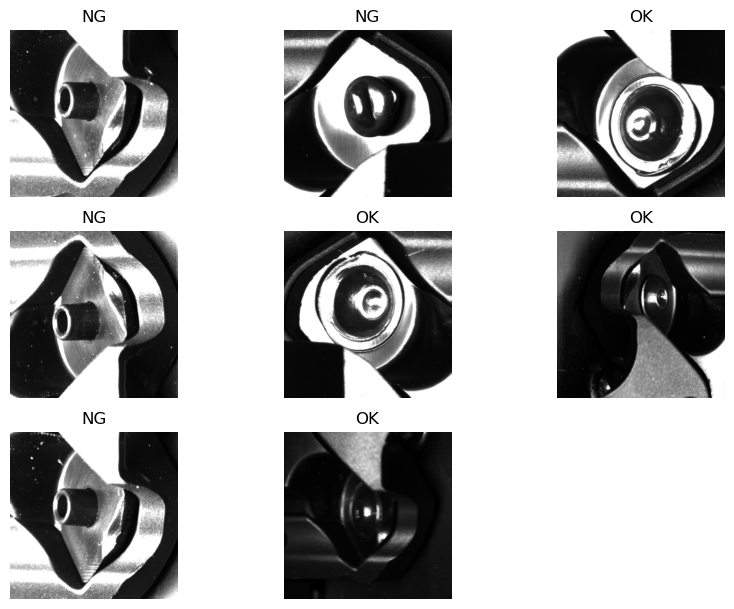

In [24]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [26]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [27]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [28]:
initial_bias = np.log([COUNT_NG/COUNT_OK])
initial_bias

array([-0.05334598])

In [29]:
weight_for_0 = (1 / COUNT_OK)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_NG)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.97
Weight for class 1: 1.03


In [30]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 600, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 600, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 300, 16)     0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 150, 150, 32)      2160      
                                                                 
 sequential_1 (Sequential)   (None, 75, 75, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 37, 37, 128)       27072     
                                                      

In [32]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
75/75 [==============================] - 42s 408ms/step - loss: 0.8278 - accuracy: 0.5750 - precision: 0.5611 - recall: 0.5822 - val_loss: 0.6922 - val_accuracy: 0.5486 - val_precision: 0.5486 - val_recall: 1.0000
Epoch 2/25
75/75 [==============================] - 30s 395ms/step - loss: 0.7584 - accuracy: 0.6033 - precision: 0.5882 - recall: 0.6164 - val_loss: 0.6907 - val_accuracy: 0.5347 - val_precision: 0.5347 - val_recall: 1.0000
Epoch 3/25
75/75 [==============================] - 31s 415ms/step - loss: 0.6424 - accuracy: 0.6667 - precision: 0.6533 - recall: 0.6712 - val_loss: 0.6937 - val_accuracy: 0.5278 - val_precision: 0.5278 - val_recall: 1.0000
Epoch 4/25
75/75 [==============================] - 32s 424ms/step - loss: 0.6642 - accuracy: 0.6683 - precision: 0.6576 - recall: 0.6644 - val_loss: 0.6900 - val_accuracy: 0.5417 - val_precision: 0.5417 - val_recall: 1.0000
Epoch 5/25
75/75 [==============================] - 32s 432ms/step - loss: 0.6016 - accuracy: 0.7050

In [33]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("factory_model_fi5.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [34]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [35]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100


75/75 [==============================] - 43s 568ms/step - loss: 0.5556 - accuracy: 0.7283 - precision: 0.7312 - recall: 0.6986 - val_loss: 0.7574 - val_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/100
75/75 [==============================] - 36s 473ms/step - loss: 0.5590 - accuracy: 0.7167 - precision: 0.7311 - recall: 0.6610 - val_loss: 6.5220 - val_accuracy: 0.7153 - val_precision: 0.6923 - val_recall: 0.8289 - lr: 0.0089
Epoch 3/100
75/75 [==============================] - 38s 504ms/step - loss: 0.5223 - accuracy: 0.7467 - precision: 0.7612 - recall: 0.6986 - val_loss: 7.5118 - val_accuracy: 0.6875 - val_precision: 0.7692 - val_recall: 0.6250 - lr: 0.0079
Epoch 4/100
75/75 [==============================] - 37s 496ms/step - loss: 0.5024 - accuracy: 0.7633 - precision: 0.7467 - recall: 0.7774 - val_loss: 0.8168 - val_accuracy: 0.8056 - val_precision: 1.0000 - val_recall: 0.6456 - lr: 0.0071
Epoch 5/100
75/75 [=============================

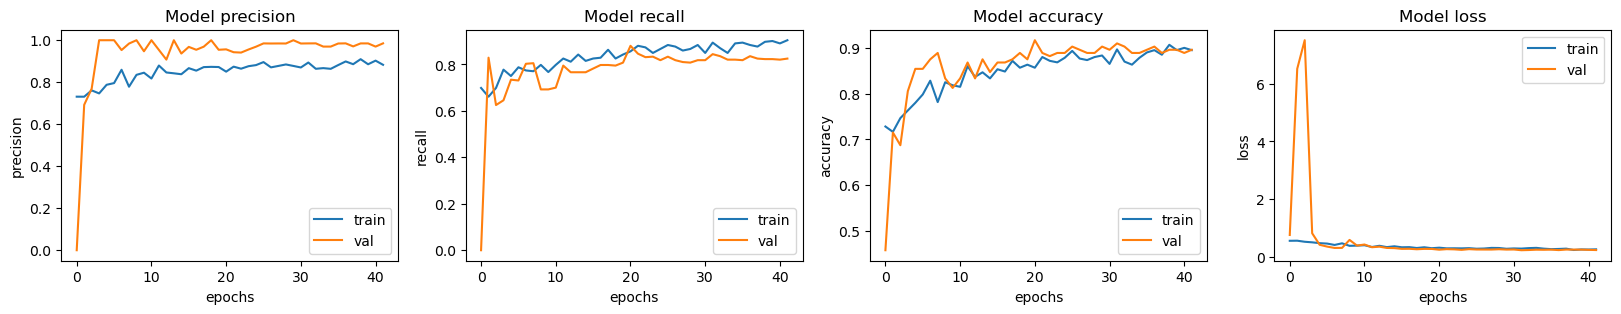

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, acc, prec, rec = model.evaluate(test_ds)

6/6 [==============================] - 2s 231ms/step - loss: 0.2265 - accuracy: 0.8511 - precision: 0.8667 - recall: 0.7222


In [38]:
y2=model.predict(test_ds)

6/6 [==============================] - 2s 141ms/step


In [39]:
model.predict(classify_ds).astype("int32")

141/141 [==============================] - 39s 271ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [40]:
model.predict(test_ds)

6/6 [==============================] - 1s 140ms/step


array([[0.8629235 ],
       [0.40859193],
       [0.07071272],
       [0.02285744],
       [0.23503044],
       [0.824403  ],
       [0.9876351 ],
       [0.02432073],
       [0.21487744],
       [0.34647694],
       [0.0121508 ],
       [0.448388  ],
       [0.32586595],
       [0.26006323],
       [0.25071213],
       [0.9927568 ],
       [0.9884604 ],
       [0.02143651],
       [0.05192406],
       [0.05771269],
       [0.01029089],
       [0.10294107],
       [0.9623439 ],
       [0.02978363],
       [0.44126332],
       [0.65488875],
       [0.08886227],
       [0.09677536],
       [0.11101935],
       [0.97705597],
       [0.02845966],
       [0.02762924],
       [0.01828177],
       [0.22535303],
       [0.00274525],
       [0.42727196],
       [0.01339503],
       [0.96414113],
       [0.06426591],
       [0.9573262 ],
       [0.92500657],
       [0.97921294],
       [0.01918399],
       [0.02938242],
       [0.9840067 ],
       [0.01165553],
       [0.06342296]], dtype=float3

In [41]:
for i in range(29):
    print(y2[i])

[0.68633115]
[0.08587187]
[0.44126332]
[0.00735285]
[0.02432073]
[0.01259524]
[0.0108828]
[0.9840067]
[0.10294107]
[0.07273696]
[0.31254488]
[0.98467606]
[0.03980088]
[0.01996795]
[0.5177662]
[0.03238807]
[0.03422361]
[0.02762924]
[0.9839941]
[0.05409806]
[0.84376764]
[0.01339503]
[0.01165553]
[0.0781886]
[0.79762805]
[0.9224773]
[0.01921718]
[0.02087464]
[0.4750484]


In [42]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

y_predict = np.argmax(model.predict(test_ds), axis=1)
y_predict

for image, label in test_ds.take(-1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


6/6 [==============================] - 1s 169ms/step
Image shape:  (8, 600, 600, 3)
Label:  [False  True False  True False False False  True]
Image shape:  (8, 600, 600, 3)
Label:  [False False  True  True False  True False False]
Image shape:  (8, 600, 600, 3)
Label:  [ True False False False  True  True False  True]
Image shape:  (8, 600, 600, 3)
Label:  [False False  True False False  True False False]
Image shape:  (8, 600, 600, 3)
Label:  [False  True False  True  True  True False False]
Image shape:  (7, 600, 600, 3)
Label:  [False  True False  True False False False]


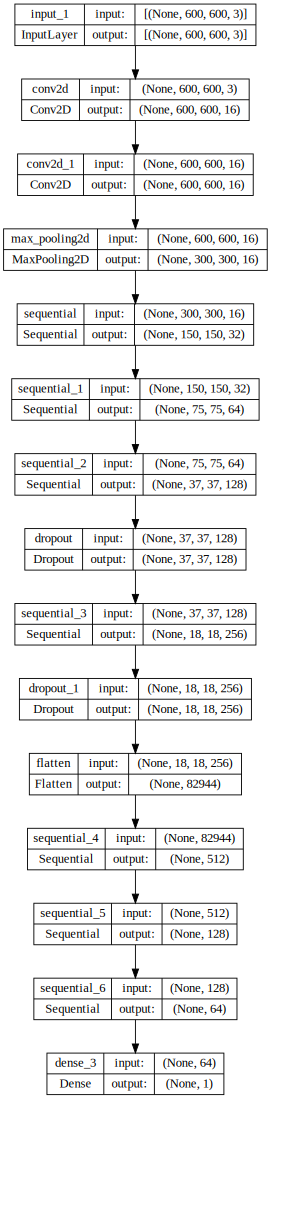

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
SVG(model_to_dot(model, show_shapes=True, dpi = 65).create(prog='dot', format='svg'))